In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('cleaned_data.csv')

In [2]:
import dash
from dash import html, dcc, callback, Input, Output
import plotly.graph_objs as go
import pandas as pd

# Adjust the income bins and labels
income_bins = [0, 20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000, np.inf]
income_labels = ['0-20k', '20-40k', '40-60k', '60-80k', '80-100k', '100-120k', '120-140k', '140-160k', '160k+']
df['IncomeGroup'] = pd.cut(df['Annual_Income'], bins=income_bins, labels=income_labels, right=False)

# Create age groups
age_bins = [14, 18, 25, 35, 45, 55, 57]  # Creating bins for the age groups
age_labels = ['14-18', '19-25', '26-35', '36-45', '46-55', '56+']
df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

# Aggregate the data by 'IncomeGroup' and 'CreditScore'
income_credit_grouped = df.groupby(['IncomeGroup', 'Credit_Score']).size().unstack(fill_value=0)


# Initialize the Dash app
app = dash.Dash(__name__)

# Dash app layout
app.layout = html.Div([
    dcc.Dropdown(
        id='category-dropdown',
        options=[
            {'label': 'Annual Income Group', 'value': 'income'},
            {'label': 'Age Group', 'value': 'age'},
            {'label': 'Occupation', 'value': 'occupation'}
        ],
        value='income'  # default value
    ),
    dcc.Graph(id='stacked-barchart')
])

def create_plotly_stacked_bar_chart(dataframe, colors):
    fig = go.Figure()

    # Calculate the total for each group (row)
    total_per_group = dataframe.sum(axis=1)

    for col in dataframe.columns:
        if col in colors:
            color = colors[col]
        else:
            color = 'grey'

        # Calculate the percentage
        percentage = (dataframe[col] / total_per_group) * 100

        # Adding the trace
        fig.add_trace(go.Bar(
            x=dataframe.index,
            y=dataframe[col],
            name=col,
            marker=dict(color=color),
            hovertemplate='%{y} (' + percentage.apply(lambda x: '{0:1.2f}%'.format(x)) + ')<extra></extra>',  # Custom hover text
        ))

    fig.update_layout(
        barmode='stack',
        xaxis=dict(title='Category'),
        yaxis=dict(title='Number of Individuals'),
        legend_title='Credit Score'
    )
    return fig


# Callback for updating the barchart
@app.callback(
    Output('stacked-barchart', 'figure'),
    [Input('category-dropdown', 'value')]
)
def update_graph(selected_category):
    colors = {'Good': 'green', 'Poor': 'red', 'Standard': 'orange'}

    if selected_category == 'income':
        # Prepare data for Income Group Plot
        income_credit_grouped = df.groupby(['IncomeGroup', 'Credit_Score']).size().unstack(fill_value=0)
        return create_plotly_stacked_bar_chart(income_credit_grouped, colors)
    elif selected_category == 'age':
        # Prepare data for Age Group Plot
        age_credit_grouped = df.groupby(['AgeGroup', 'Credit_Score']).size().unstack(fill_value=0)
        return create_plotly_stacked_bar_chart(age_credit_grouped, colors)
    else:
        # Prepare data for Occupation Plot
        occupation_credit_grouped = df.groupby(['Occupation', 'Credit_Score']).size().unstack(fill_value=0)
        return create_plotly_stacked_bar_chart(occupation_credit_grouped, colors)

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, port=8051)

C:\Users\timow\AppData\Local\Temp\ipykernel_21144\1422398292.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_credit_grouped = df.groupby(['IncomeGroup', 'Credit_Score']).size().unstack(fill_value=0)


C:\Users\timow\AppData\Local\Temp\ipykernel_21144\1422398292.py:80: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\timow\AppData\Local\Temp\ipykernel_21144\1422398292.py:84: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [3]:
df = pd.read_csv('cleaned_data.csv')
df = df.dropna(subset=['Credit_Score'])

# Create a function to categorize the change
def credit_score_change(row):
    if row['Credit_Score'] == row['Previous_Score']:
        return 'No Change'
    elif row['Credit_Score'] == 'Poor' and row['Previous_Score'] == 'Standard':
        return 'Decline'
    elif row['Credit_Score'] == 'Poor' and row['Previous_Score'] == 'Good':
        return 'Decline'
    elif row['Credit_Score'] == 'Standard' and row['Previous_Score'] == 'Good':
        return 'Decline'
    elif row['Credit_Score'] == 'Good' and row['Previous_Score'] == 'Poor':
        return 'Improvement'
    elif row['Credit_Score'] == 'Good' and row['Previous_Score'] == 'Standard':
        return 'Improvement'
    elif row['Credit_Score'] == 'Standard' and row['Previous_Score'] == 'Poor':
        return 'Improvement'
    else:
        return 'No Change'

# Create a shifted version of the credit score column
df['Previous_Score'] = df.groupby('Customer_ID')['Credit_Score'].shift(1)

# Apply the function to categorize each change
df['Credit_Score_Change'] = df.apply(credit_score_change, axis=1)

# drop Previous_Score column
df = df.drop(columns=['Previous_Score'])

columns = ['Age', 'Annual_Income',
       'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour',
       'Behaviour_Spending_Level', 'Behaviour_Value_Size', 'Monthly_Balance']


def column_change(row):
    if pd.isna(row[f"Previous_{col}"]) or pd.isna(row[col]) or row[col] == row[f"Previous_{col}"]:
        return 'No change'
    else:
        return 'Changed'
    
for col in columns:
    df[f'Previous_{col}'] = df.groupby('Customer_ID')[col].shift(1)
    df[f'{col}_Change'] = df.apply(column_change, axis=1)
    df = df.drop(columns=[f'Previous_{col}'])

df.head(24)

,ID,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,...,Outstanding_Debt_Change,Credit_Utilization_Ratio_Change,Credit_History_Age_Change,Payment_of_Min_Amount_Change,Total_EMI_per_month_Change,Amount_invested_monthly_Change,Payment_Behaviour_Change,Behaviour_Spending_Level_Change,Behaviour_Value_Size_Change,Monthly_Balance_Change
0,0x1628a,CUS_0x1000,January,17,Lawyer,30625.94,2706.16,6,5,27,...,No change,No change,No change,No change,No change,No change,No change,No change,No change,No change
1,0x1628b,CUS_0x1000,February,17,Lawyer,30625.94,NaN,6,5,27,...,No change,Changed,Changed,No change,No change,Changed,Changed,Changed,Changed,Changed
2,0x1628c,CUS_0x1000,March,17,Lawyer,30625.94,2706.16,6,5,27,...,No change,Changed,Changed,No change,No change,Changed,Changed,No change,Changed,Changed
3,0x1628d,CUS_0x1000,April,17,Lawyer,30625.94,2706.16,6,5,27,...,No change,Changed,Changed,No change,No change,Changed,Changed,Changed,Changed,Changed
4,0x1628e,CUS_0x1000,May,17,Lawyer,30625.94,2706.16,6,5,27,...,No change,Changed,Changed,No change,No change,Changed,Changed,Changed,Changed,Changed
5,0x1628f,CUS_0x1000,June,18,Lawyer,30625.94,2706.16,6,5,27,...,No change,Changed,Changed,No change,No change,Changed,Changed,Changed,Changed,Changed
6,0x16290,CUS_0x1000,July,18,Lawyer,30625.94,2706.16,6,5,27,...,No change,Changed,Changed,No change,No change,Changed,Changed,Changed,No change,Changed
7,0x16291,CUS_0x1000,August,18,Lawyer,30625.94,2706.16,6,5,27,...,No change,Changed,Changed,No change,No change,Changed,Changed,Changed,Changed,Changed
12,0x66a2,CUS_0x1009,January,25,Mechanic,52312.68,4250.39,6,5,17,...,No change,No change,No change,No change,No change,No change,No change,No change,No change,No change
13,0x66a3,CUS_0x1009,February,25,Mechanic,52312.68,4250.39,6,5,17,...,No change,Changed,Changed,Changed,No change,Changed,Changed,Changed,No change,Changed


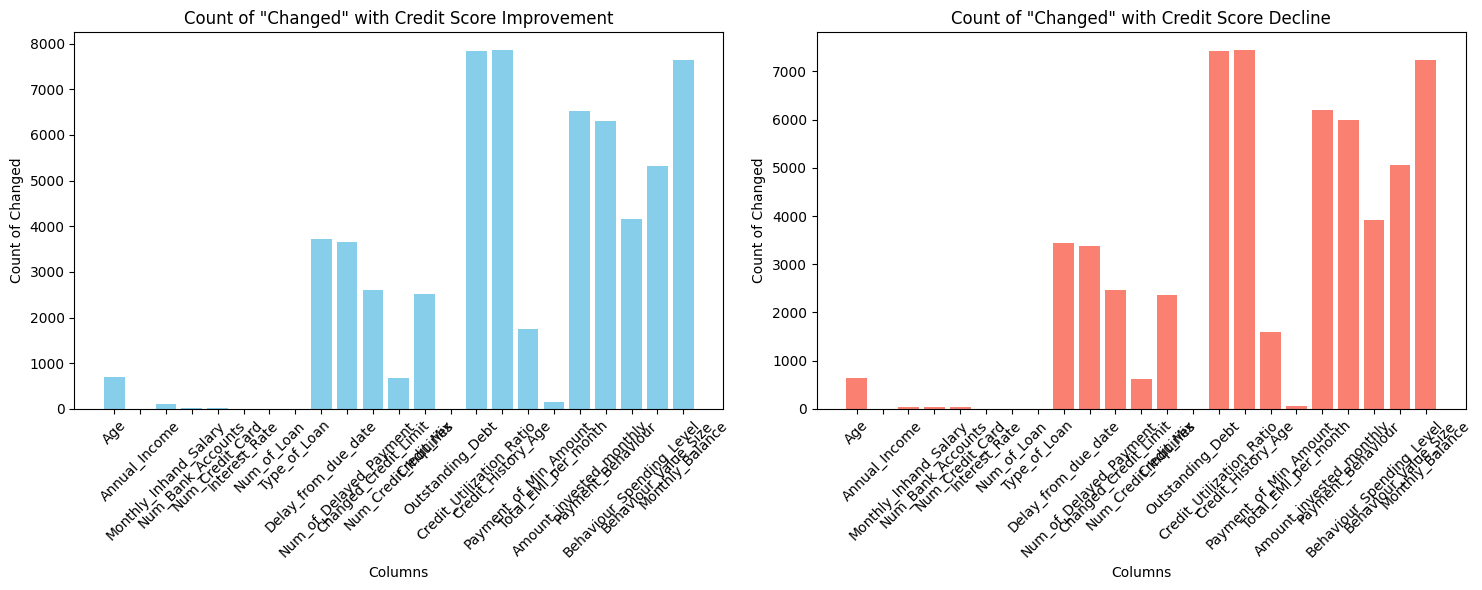

In [4]:
import matplotlib.pyplot as plt

# List of columns to consider
columns = ['Age', 'Annual_Income',
       'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour',
       'Behaviour_Spending_Level', 'Behaviour_Value_Size', 'Monthly_Balance']

# Filter DataFrame for "Improvement" and "Decline" in Credit_Score_Change
improved_df = df[df['Credit_Score_Change'] == 'Improvement']
declined_df = df[df['Credit_Score_Change'] == 'Decline']

# Count "Changed" for each column in the list
changed_counts_improved = [improved_df[f'{col}_Change'].value_counts().get('Changed', 0) for col in columns]
changed_counts_declined = [declined_df[f'{col}_Change'].value_counts().get('Changed', 0) for col in columns]

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot for "Improvement"
axes[0].bar(columns, changed_counts_improved, color='skyblue')
axes[0].set_title('Count of "Changed" with Credit Score Improvement')
axes[0].set_xlabel('Columns')
axes[0].set_ylabel('Count of Changed')
axes[0].tick_params(axis='x', rotation=45)

# Plot for "Decline"
axes[1].bar(columns, changed_counts_declined, color='salmon')
axes[1].set_title('Count of "Changed" with Credit Score Decline')
axes[1].set_xlabel('Columns')
axes[1].set_ylabel('Count of Changed')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


"""
I dont think this is very helpful. 
If we want to use it, good and bad changed need to be defined for every columns.
"""

In [5]:
improved_df

,ID,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,...,Outstanding_Debt_Change,Credit_Utilization_Ratio_Change,Credit_History_Age_Change,Payment_of_Min_Amount_Change,Total_EMI_per_month_Change,Amount_invested_monthly_Change,Payment_Behaviour_Change,Behaviour_Spending_Level_Change,Behaviour_Value_Size_Change,Monthly_Balance_Change
27,0x1ef9,CUS_0x100b,April,18,Media_Manager,113781.39,9549.78,1,4,1,...,No change,Changed,Changed,No change,No change,No change,No change,No change,No change,Changed
30,0x1efc,CUS_0x100b,July,19,Media_Manager,113781.39,9549.78,1,4,1,...,No change,Changed,Changed,Changed,No change,Changed,Changed,Changed,Changed,Changed
63,0x19419,CUS_0x1015,April,27,Journalist,46951.02,NaN,7,4,16,...,No change,Changed,Changed,No change,No change,No change,Changed,Changed,Changed,Changed
147,0x21d89,CUS_0x1038,April,27,Architect,129473.16,10959.43,3,4,10,...,No change,Changed,Changed,No change,No change,Changed,Changed,Changed,Changed,Changed
150,0x21d8c,CUS_0x1038,July,28,Architect,129473.16,10959.43,3,4,10,...,No change,Changed,Changed,No change,No change,Changed,Changed,No change,Changed,Changed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149825,0x19187,CUS_0xfcb,June,24,Lawyer,10805.56,627.46,5,6,15,...,No change,Changed,Changed,Changed,No change,Changed,Changed,No change,Changed,Changed
149933,0x18833,CUS_0xfea,June,33,Manager,44264.41,3755.70,3,3,6,...,No change,Changed,Changed,No change,No change,Changed,Changed,Changed,Changed,Changed
149970,0xfabc,CUS_0xff6,July,19,Doctor,117639.92,9727.33,5,6,1,...,No change,Changed,Changed,No change,No change,Changed,No change,No change,No change,No change
149981,0x61eb,CUS_0xffc,June,18,Musician,60877.17,5218.10,6,8,27,...,No change,Changed,Changed,No change,No change,No change,Changed,Changed,Changed,Changed
